<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Stuff

###Import all libraries

In [17]:
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

###Import datasets

In [18]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/hate_crime/hate_crime.csv", on_bad_lines='skip')
city_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/city/ACSST1Y2022.S0101-Data.csv", on_bad_lines='skip')
county_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ACSDP1Y2022.DP05-Data.csv", on_bad_lines='skip')

#Data Cleaning

In [19]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [20]:
#fix the headers
city_demo_df = fixHeaders(city_demo_df)
county_demo_df = fixHeaders(county_demo_df)

In [21]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [22]:
splitArea(city_demo_df)
splitArea(county_demo_df)

city_demo_df.head()

,Geography,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Margin of Error!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 9 years,Margin of Error!!Total!!Total population!!AGE!!5 to 9 years,Estimate!!Total!!Total population!!AGE!!10 to 14 years,Margin of Error!!Total!!Total population!!AGE!!10 to 14 years,...,Estimate!!Percent Female!!Total population!!SUMMARY INDICATORS!!Child dependency ratio,Margin of Error!!Percent Female!!Total population!!SUMMARY INDICATORS!!Child dependency ratio,Estimate!!Percent Female!!Total population!!PERCENT ALLOCATED!!Sex,Margin of Error!!Percent Female!!Total population!!PERCENT ALLOCATED!!Sex,Estimate!!Percent Female!!Total population!!PERCENT ALLOCATED!!Age,Margin of Error!!Percent Female!!Total population!!PERCENT ALLOCATED!!Age,NaN,pug_agency_name,agency_type_name,state_name
1,1600000US0103076,"Auburn city, Alabama",80009,20,3657,1311,3809,1134,4348,1136,...,(X),(X),(X),(X),(X),(X),NaN,Auburn,City,Alabama
2,1600000US0107000,"Birmingham city, Alabama",196353,868,11495,2020,11631,2173,9404,2476,...,(X),(X),(X),(X),(X),(X),NaN,Birmingham,City,Alabama
3,1600000US0121184,"Dothan city, Alabama",70524,678,4549,468,5059,662,4146,592,...,(X),(X),(X),(X),(X),(X),NaN,Dothan,City,Alabama
4,1600000US0135896,"Hoover city, Alabama",92427,45,5778,1406,5805,1516,7377,2051,...,(X),(X),(X),(X),(X),(X),NaN,Hoover,City,Alabama
5,1600000US0137000,"Huntsville city, Alabama",222363,2301,12180,1698,13883,1837,10494,1917,...,(X),(X),(X),(X),(X),(X),NaN,Huntsville,City,Alabama


In [23]:
#only consider 2022 crime data from cities and counties
crime_df = crime_df[(crime_df['data_year'] == 2022) & ((crime_df['agency_type_name'] == "City") | (crime_df['agency_type_name'] == "County"))]

In [75]:
def fixColumns(df):
  removalList = {"SEX AND AGE!!", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalList:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fixColumns(county_demo_df)
city_demo_df.columns = fixColumns(city_demo_df)

In [84]:
def preprocessCityDf(df_s0101):
    formatted_df = df_s0101.copy(deep=True)

    formatted_df['25 to 34 years'] = df_s0101['25 to 29 years'] + df_s0101['30 to 34 years']
    formatted_df['35 to 44 years'] = df_s0101['35 to 39 years'] + df_s0101['40 to 44 years']
    formatted_df['45 to 54 years'] = df_s0101['45 to 49 years'] + df_s0101['50 to 54 years']
    formatted_df['65 to 74 years'] = df_s0101['65 to 69 years'] + df_s0101['70 to 74 years']
    formatted_df['75 to 84 years'] = df_s0101['75 to 79 years'] + df_s0101['80 to 84 years']

    return formatted_df

city_demo_df = preprocessCityDf(city_demo_df)

###Combine the datasets

In [85]:
# Create new columns that combine data shared between all the city and county entries
overlapping_columns = set(city_demo_df.columns).intersection(set(county_demo_df.columns))
print(overlapping_columns)
demo_df = pd.concat([city_demo_df[list(overlapping_columns)],county_demo_df[list(overlapping_columns)]])

{'15 to 19 years', 'Percent!!85 years and over', 'Under 5 years', '45 to 54 years', '60 to 64 years', 'Margin of Error!!55 to 59 years', 'Percent!!10 to 14 years', 'Percent!!5 to 9 years', '35 to 44 years', 'Percent!!20 to 24 years', 'Percent!!15 to 19 years', 'state_name', 'Margin of Error!!60 to 64 years', 'Margin of Error!!20 to 24 years', 'Percent!!60 to 64 years', 'Margin of Error!!5 to 9 years', '20 to 24 years', 'Margin of Error!!85 years and over', 'Margin of Error!!Under 5 years', '5 to 9 years', 'nan', '25 to 34 years', '10 to 14 years', 'Percent!!55 to 59 years', 'agency_type_name', '65 to 74 years', '85 years and over', 'Percent!!Under 5 years', 'Percent!!Total population', '75 to 84 years', '55 to 59 years', 'Total population', 'Margin of Error!!10 to 14 years', 'Margin of Error!!Total population', 'Margin of Error!!15 to 19 years', 'pug_agency_name', 'Geographic Area Name', 'Geography'}


In [86]:
merged_df = pd.merge(crime_df, demo_df, on=["pug_agency_name", "agency_type_name", "state_name"])

In [87]:
merged_df

,incident_id,data_year,ori,pug_agency_name,pub_agency_unit,agency_type_name,state_abbr,state_name,division_name,region_name,...,Percent!!Under 5 years,Percent!!Total population,75 to 84 years,55 to 59 years,Total population,Margin of Error!!10 to 14 years,Margin of Error!!Total population,Margin of Error!!15 to 19 years,Geographic Area Name,Geography
0,1433145,2022,AL0020000,Mobile,NaN,County,AL,Alabama,East South Central,South,...,6.2,411411,21289,24935,411411,2590,*****,659,"Mobile County, Alabama",0500000US01097
1,1468107,2022,AL0020000,Mobile,NaN,County,AL,Alabama,East South Central,South,...,6.2,411411,21289,24935,411411,2590,*****,659,"Mobile County, Alabama",0500000US01097
2,1468108,2022,AL0020000,Mobile,NaN,County,AL,Alabama,East South Central,South,...,6.2,411411,21289,24935,411411,2590,*****,659,"Mobile County, Alabama",0500000US01097
3,1475554,2022,AL0020000,Mobile,NaN,County,AL,Alabama,East South Central,South,...,6.2,411411,21289,24935,411411,2590,*****,659,"Mobile County, Alabama",0500000US01097
4,1475556,2022,AL0020000,Mobile,NaN,County,AL,Alabama,East South Central,South,...,6.2,411411,21289,24935,411411,2590,*****,659,"Mobile County, Alabama",0500000US01097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6069,1466885,2022,WY0110100,Cheyenne,NaN,City,WY,Wyoming,Mountain,West,...,5.4,(X),19221709,4365,64623,832,48,812,"Cheyenne city, Wyoming",1600000US5613900
6070,1469143,2022,WY0110100,Cheyenne,NaN,City,WY,Wyoming,Mountain,West,...,5.4,(X),19221709,4365,64623,832,48,812,"Cheyenne city, Wyoming",1600000US5613900
6071,1469147,2022,WY0110100,Cheyenne,NaN,City,WY,Wyoming,Mountain,West,...,5.4,(X),19221709,4365,64623,832,48,812,"Cheyenne city, Wyoming",1600000US5613900
6072,1470676,2022,WY0110100,Cheyenne,NaN,City,WY,Wyoming,Mountain,West,...,5.4,(X),19221709,4365,64623,832,48,812,"Cheyenne city, Wyoming",1600000US5613900


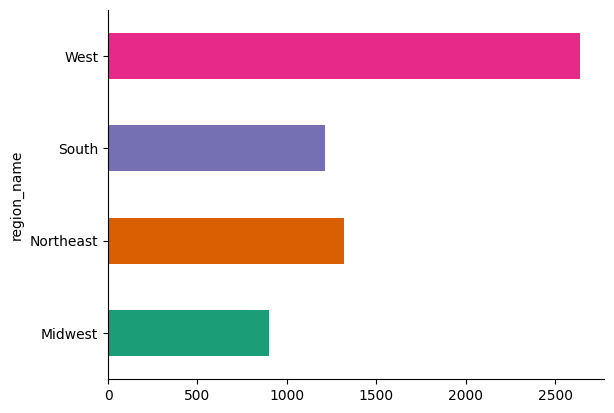

In [88]:
merged_df.groupby('region_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

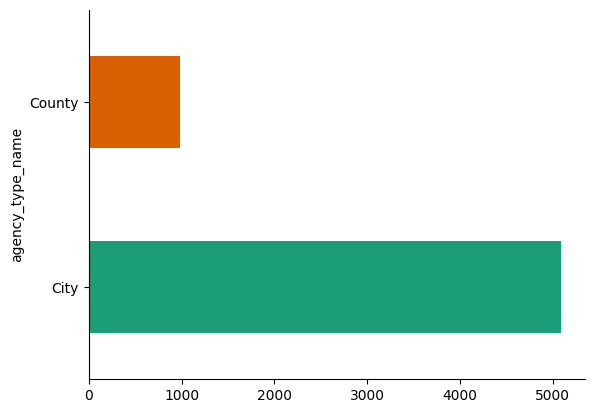

In [89]:
merged_df.groupby('agency_type_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

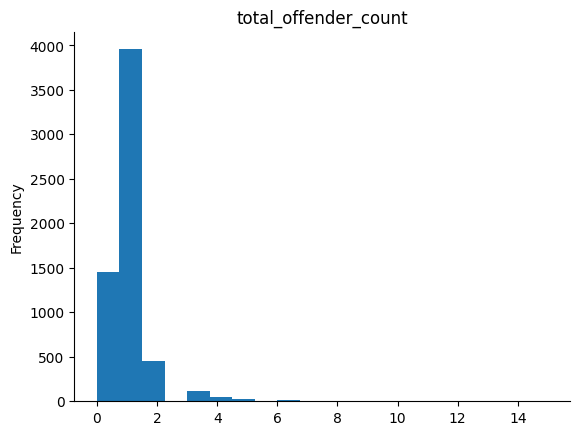

In [90]:
merged_df['total_offender_count'].plot(kind='hist', bins=20, title='total_offender_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

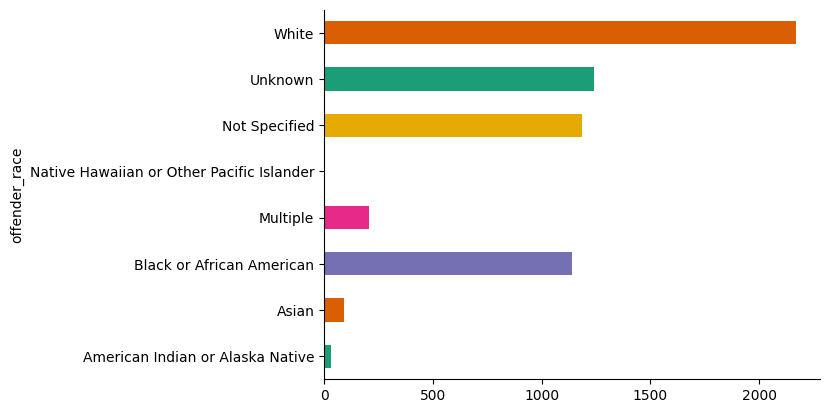

In [91]:
merged_df.groupby('offender_race').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

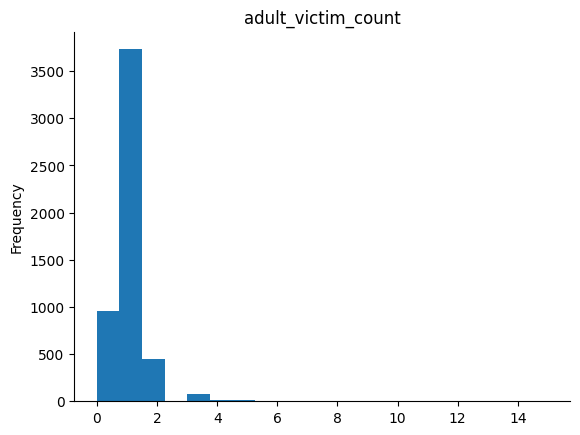

In [92]:
merged_df['adult_victim_count'].plot(kind='hist', bins=20, title='adult_victim_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

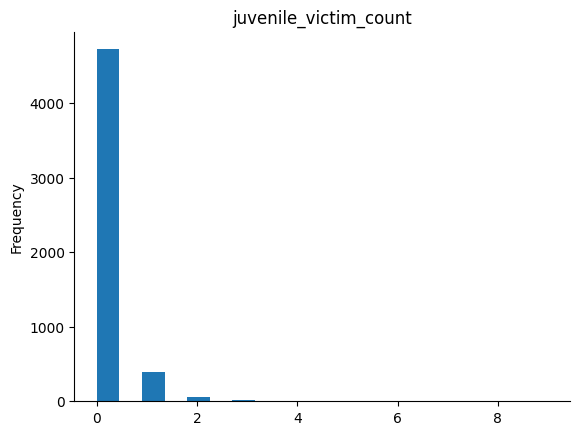

In [93]:
merged_df['juvenile_victim_count'].plot(kind='hist', bins=20, title='juvenile_victim_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

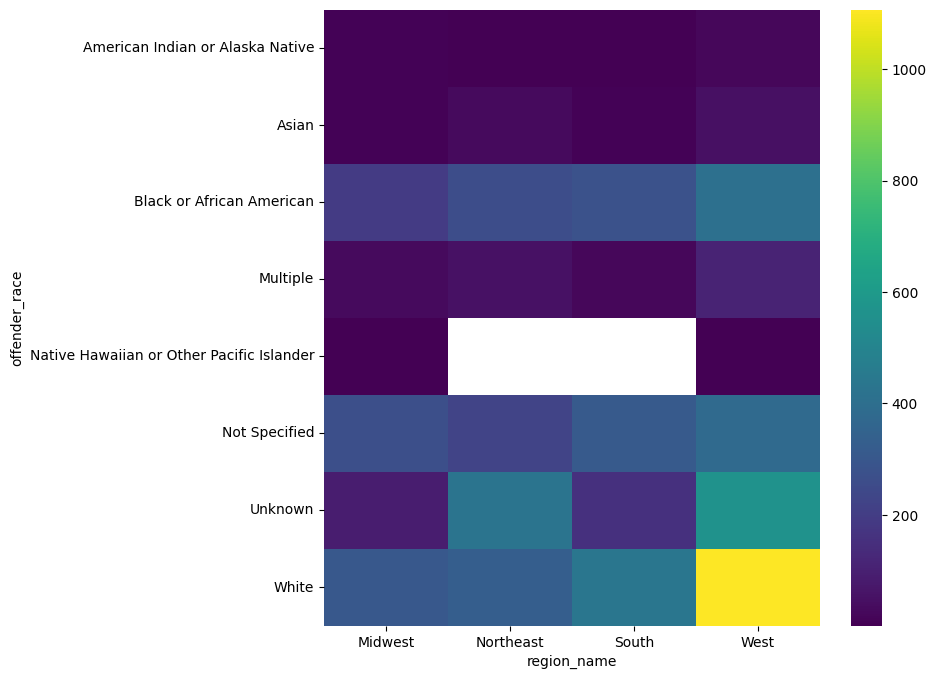

In [94]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in merged_df.groupby('region_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('region_name')
_ = plt.ylabel('offender_race')